# 01 Server Rackmount Forecast

Quick validation notebook for the `data/processed/synosales_cleaned.parquet` output. Once the structure is confirmed, lift the aggregation logic into a production module under `src/` as part of the export-to-module plan.

In [42]:
import numpy as np
import sys
from pathlib import Path
import pandas as pd
import warnings
import sklearn
import itertools
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
from xgboost import XGBRegressor


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
repo = Path("/Volumes/docker/syno_bi/repo")
df = pd.read_parquet(repo / "data/processed/synosales_cleaned.parquet")

suite_NAS = df[df["source_sheet"].isin(["2023", "2024"])]
suite_C2 = df[df["source_sheet"].isin(["2023-C2", "2024-C2"])]

In [4]:
suite_NAS_clean = suite_NAS[["PI", "Customer", "ItemCode", "Product", "Quantity", "usd_adjusted_price", "usd_adjusted_total", "InvDate", "Country", "Type", "sub_cat", "Year", "Region"]]
suite_C2_clean = suite_C2[["PI", "Customer", "ItemCode", "Product", "Quantity", "usd_adjusted_price", "usd_adjusted_total", "InvDate", "Country", "Type", "sub_cat", "Year", "Region"]]

In [5]:
suite_NAS_clean["InvDate"] = pd.to_datetime(suite_NAS_clean["InvDate"])
suite_NAS_clean["usd_adjusted_total"] = suite_NAS_clean["usd_adjusted_total"].astype(float)

/var/folders/dt/7vnpb4hn01d19x7dfz27zs5h0000gn/T/ipykernel_67042/3204520262.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suite_NAS_clean["InvDate"] = pd.to_datetime(suite_NAS_clean["InvDate"])
/var/folders/dt/7vnpb4hn01d19x7dfz27zs5h0000gn/T/ipykernel_67042/3204520262.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suite_NAS_clean["usd_adjusted_total"] = suite_NAS_clean["usd_adjusted_total"].astype(float)


In [6]:
monthly_rev = (
    suite_NAS_clean.groupby(pd.Grouper(key="InvDate", freq="M"))["usd_adjusted_total"]
    .sum()
    .reset_index()
)

/var/folders/dt/7vnpb4hn01d19x7dfz27zs5h0000gn/T/ipykernel_67042/2786123579.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  suite_NAS_clean.groupby(pd.Grouper(key="InvDate", freq="M"))["usd_adjusted_total"]


Baseline

In [7]:
train = monthly_rev[monthly_rev["InvDate"] <= "2024-09-30"]
test  = monthly_rev[monthly_rev["InvDate"] >  "2024-09-30"]

In [8]:

model = SARIMAX(train["usd_adjusted_total"], order=(1,1,1), seasonal_order=(1,1,1,12))
fit = model.fit()
forecast = fit.forecast(steps=3)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.00505D+00    |proj g|=  2.34245D+00

At iterate    5    f=  6.75201D+00    |proj g|=  2.51686D-02

At iterate   10    f=  6.74912D+00    |proj g|=  2.35799D-02

At iterate   15    f=  6.74852D+00    |proj g|=  1.96238D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     27      1     0     0   1.043D-05   6.749D+00
  F =   6.7485121218985729     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/tonychu/Git Repository/syno_prediction/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


In [9]:
forecast = fit.get_forecast(steps=3)
pred_mean = forecast.predicted_mean
conf_int = forecast.conf_int(alpha=0.05)

In [ ]:
lower_col, upper_col = conf_int.columns

sarimax_forecast_df = pd.DataFrame(
    {
        'forecast': pred_mean.values,
        'forecast_lower': conf_int[lower_col].values,
        'forecast_upper': conf_int[upper_col].values,
    },
    index=pd.to_datetime(test['InvDate'].reset_index(drop=True)),
)
sarimax_forecast_df.index.name = 'InvDate'
sarimax_forecast_df

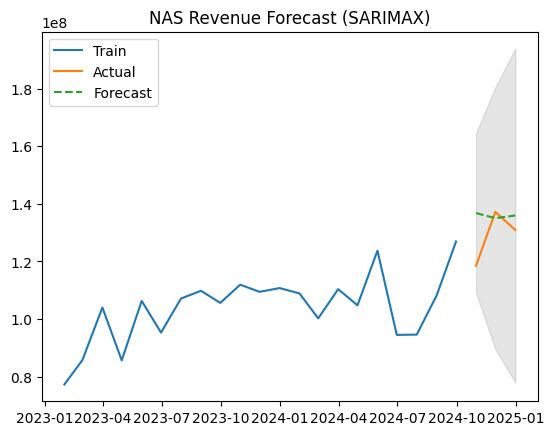

In [10]:


plt.plot(train["InvDate"], train["usd_adjusted_total"], label="Train")
plt.plot(test["InvDate"], test["usd_adjusted_total"], label="Actual")
plt.plot(test["InvDate"], pred_mean, label="Forecast", linestyle="--")
plt.fill_between(test["InvDate"], conf_int.iloc[:,0], conf_int.iloc[:,1], color="gray", alpha=0.2)
plt.legend()
plt.title("NAS Revenue Forecast (SARIMAX)")
plt.show()

In [11]:
mape = np.mean(
    np.abs(test["usd_adjusted_total"].values - pred_mean.values)
    / test["usd_adjusted_total"].values
) * 100
print(f"MAPE: {mape:.2f}%")

MAPE: 6.98%


Loop Through

In [16]:
warnings.filterwarnings("ignore")

y_train = train.set_index("InvDate")["usd_adjusted_total"]
y_test  = test.set_index("InvDate")["usd_adjusted_total"]

# Optional variance stabilization
# y_train = np.log1p(y_train)
# y_test  = np.log1p(y_test)

p = d = q = range(0, 3)
P = D = Q = range(0, 3)
seasonal_period = 12

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], seasonal_period) for x in itertools.product(P, D, Q)]

best_mape = float("inf")
best_cfg  = None
best_pred = None

for order in pdq:
    for s_order in seasonal_pdq:
        try:
            model = SARIMAX(
                y_train,
                order=order,
                seasonal_order=s_order,
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            fit = model.fit(disp=False)
            forecast = fit.forecast(steps=len(y_test))
            
            mape = mean_absolute_percentage_error(y_test, forecast) * 100
            print(f"order={order}, seasonal={s_order}, MAPE={mape:.2f}%")

            if mape < best_mape:
                best_mape = mape
                best_cfg = (order, s_order)
                best_pred = forecast

            # Early stop if requirement met
            if mape < 2:
                break
        except Exception:
            continue
    if best_mape < 2:
        break

if best_cfg is not None:
    print(f"\n✅ Best configuration: Order={best_cfg[0]}, Seasonal={best_cfg[1]}, MAPE={best_mape:.2f}%")
else:
    print("\n⚠️ No combination achieved MAPE < 2%.")
    print(f"Lowest MAPE achieved: {best_mape:.2f}%")


⚠️ No combination achieved MAPE < 2%.
Lowest MAPE achieved: inf%


In [17]:
print("Train nulls:", y_train.isna().sum())
print("Test nulls:", y_test.isna().sum())
print("Train min:", y_train.min(), "Test min:", y_test.min())

Train nulls: 0
Test nulls: 0
Train min: 77289809.39078 Test min: 118489547.61299999


Stablize with log transform

In [18]:
y_train = np.log1p(train.set_index("InvDate")["usd_adjusted_total"])
y_test  = np.log1p(test.set_index("InvDate")["usd_adjusted_total"])

In [19]:
y_train = y_train.asfreq('M')
y_test = y_test.asfreq('M')

In [20]:
p = d = q = range(0, 2)
P = D = Q = range(0, 2)
seasonal_period = 12

In [21]:
warnings.filterwarnings("ignore")

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], seasonal_period) for x in itertools.product(P, D, Q)]

best_mape = float("inf")
best_cfg  = None
best_pred = None

for order in pdq:
    for s_order in seasonal_pdq:
        try:
            model = SARIMAX(
                y_train,
                order=order,
                seasonal_order=s_order,
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            fit = model.fit(disp=False)
            forecast_log = fit.forecast(steps=len(y_test))
            forecast = np.expm1(forecast_log)  # invert log
            actual = np.expm1(y_test)

            mape = mean_absolute_percentage_error(actual, forecast) * 100
            print(f"order={order}, seasonal={s_order}, MAPE={mape:.2f}%")

            if mape < best_mape:
                best_mape = mape
                best_cfg = (order, s_order)
                best_pred = forecast

            if mape < 2:
                break
        except Exception as e:
            print(f"⚠️ Failed for order={order}, seasonal={s_order} → {e}")
            continue
    if best_mape < 2:
        break

if best_cfg is not None:
    print(f"\n✅ Best configuration: Order={best_cfg[0]}, Seasonal={best_cfg[1]}, MAPE={best_mape:.2f}%")
else:
    print(f"\n⚠️ No combination achieved MAPE < 2%. Lowest MAPE achieved: {best_mape:.2f}%")

⚠️ Failed for order=(0, 0, 0), seasonal=(0, 0, 0, 12) → name 'mean_absolute_percentage_error' is not defined
⚠️ Failed for order=(0, 0, 0), seasonal=(0, 0, 1, 12) → name 'mean_absolute_percentage_error' is not defined
⚠️ Failed for order=(0, 0, 0), seasonal=(0, 1, 0, 12) → name 'mean_absolute_percentage_error' is not defined
⚠️ Failed for order=(0, 0, 0), seasonal=(0, 1, 1, 12) → name 'mean_absolute_percentage_error' is not defined
⚠️ Failed for order=(0, 0, 0), seasonal=(1, 0, 0, 12) → name 'mean_absolute_percentage_error' is not defined
⚠️ Failed for order=(0, 0, 0), seasonal=(1, 0, 1, 12) → name 'mean_absolute_percentage_error' is not defined
⚠️ Failed for order=(0, 0, 0), seasonal=(1, 1, 0, 12) → name 'mean_absolute_percentage_error' is not defined
⚠️ Failed for order=(0, 0, 0), seasonal=(1, 1, 1, 12) → name 'mean_absolute_percentage_error' is not defined
⚠️ Failed for order=(0, 0, 1), seasonal=(0, 0, 0, 12) → name 'mean_absolute_percentage_error' is not defined
⚠️ Failed for order

In [22]:
print("Train index:\n", y_train.index)
print("Test index:\n", y_test.index)
print("Train freq:", y_train.index.freq)
print("Test freq:", y_test.index.freq)
print("Train length:", len(y_train))
print("Test length:", len(y_test))

Train index:
 DatetimeIndex(['2023-01-31', '2023-02-28', '2023-03-31', '2023-04-30',
               '2023-05-31', '2023-06-30', '2023-07-31', '2023-08-31',
               '2023-09-30', '2023-10-31', '2023-11-30', '2023-12-31',
               '2024-01-31', '2024-02-29', '2024-03-31', '2024-04-30',
               '2024-05-31', '2024-06-30', '2024-07-31', '2024-08-31',
               '2024-09-30'],
              dtype='datetime64[ns]', name='InvDate', freq='ME')
Test index:
 DatetimeIndex(['2024-10-31', '2024-11-30', '2024-12-31'], dtype='datetime64[ns]', name='InvDate', freq='ME')
Train freq: <MonthEnd>
Test freq: <MonthEnd>
Train length: 21
Test length: 3


In [23]:
warnings.filterwarnings("ignore")

# ---- Log transform for stability ----
y_train = np.log1p(train.set_index("InvDate")["usd_adjusted_total"])
y_test  = np.log1p(test.set_index("InvDate")["usd_adjusted_total"])

# Ensure continuous monthly frequency
y_train = y_train.asfreq("M")
y_test = y_test.asfreq("M")

# ---- Smaller parameter space ----
p = q = range(0, 3)
d = [0, 1]
P = Q = range(0, 2)
D = [0]  # disable seasonal differencing
seasonal_period = 12

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], seasonal_period) for x in itertools.product(P, D, Q)]

best_mape = float("inf")
best_cfg  = None
best_pred = None

for order in pdq:
    for s_order in seasonal_pdq:
        try:
            model = SARIMAX(
                y_train,
                order=order,
                seasonal_order=s_order,
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            fit = model.fit(disp=False)
            forecast_log = fit.forecast(steps=len(y_test))
            if np.any(np.isnan(forecast_log)):
                print(f"⚠️ NaN forecast for order={order}, seasonal={s_order}")
                continue

            forecast = np.expm1(forecast_log)
            actual = np.expm1(y_test)

            mape = mean_absolute_percentage_error(actual, forecast) * 100
            print(f"order={order}, seasonal={s_order}, MAPE={mape:.2f}%")

            if mape < best_mape:
                best_mape = mape
                best_cfg = (order, s_order)
                best_pred = forecast

            if mape < 2:
                break
        except Exception as e:
            print(f"⚠️ Failed for {order}, {s_order} → {e}")
            continue
    if best_mape < 2:
        break

if best_cfg is not None:
    print(f"\n✅ Best configuration: Order={best_cfg[0]}, Seasonal={best_cfg[1]}, MAPE={best_mape:.2f}%")
else:
    print(f"\n⚠️ No combination achieved MAPE < 2%. Lowest MAPE achieved: {best_mape:.2f}%")

⚠️ Failed for (0, 0, 0), (0, 0, 0, 12) → name 'mean_absolute_percentage_error' is not defined
⚠️ Failed for (0, 0, 0), (0, 0, 1, 12) → name 'mean_absolute_percentage_error' is not defined
⚠️ Failed for (0, 0, 0), (1, 0, 0, 12) → name 'mean_absolute_percentage_error' is not defined
⚠️ Failed for (0, 0, 0), (1, 0, 1, 12) → name 'mean_absolute_percentage_error' is not defined
⚠️ Failed for (0, 0, 1), (0, 0, 0, 12) → name 'mean_absolute_percentage_error' is not defined
⚠️ Failed for (0, 0, 1), (0, 0, 1, 12) → name 'mean_absolute_percentage_error' is not defined
⚠️ Failed for (0, 0, 1), (1, 0, 0, 12) → name 'mean_absolute_percentage_error' is not defined
⚠️ Failed for (0, 0, 1), (1, 0, 1, 12) → name 'mean_absolute_percentage_error' is not defined
⚠️ Failed for (0, 0, 2), (0, 0, 0, 12) → name 'mean_absolute_percentage_error' is not defined
⚠️ Failed for (0, 0, 2), (0, 0, 1, 12) → name 'mean_absolute_percentage_error' is not defined
⚠️ Failed for (0, 0, 2), (1, 0, 0, 12) → name 'mean_absolute

In [28]:
# log transform to stabilize variance
y_train = np.log1p(train.set_index("InvDate")["usd_adjusted_total"])
y_test  = np.log1p(test.set_index("InvDate")["usd_adjusted_total"])

# fit Holt-Winters with additive trend & seasonal components
hw_model = ExponentialSmoothing(
    y_train,
    trend="add",
    seasonal="add",
    seasonal_periods=12
).fit(optimized=True)

# forecast 3 months ahead
forecast_log = hw_model.forecast(steps=len(y_test))
forecast = np.expm1(forecast_log)
actual   = np.expm1(y_test)

mape = mean_absolute_percentage_error(actual, forecast) * 100
print(f"MAPE: {mape:.2f}%")

# visualize
import matplotlib.pyplot as plt
plt.plot(np.expm1(y_train), label="Train")
plt.plot(np.expm1(y_test), label="Actual")
plt.plot(forecast, label="Forecast", linestyle="--")
plt.legend()
plt.title("Holt-Winters NAS Revenue Forecast")
plt.show()

ValueError: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.

Remove Seasonality

MAPE: 14.91%


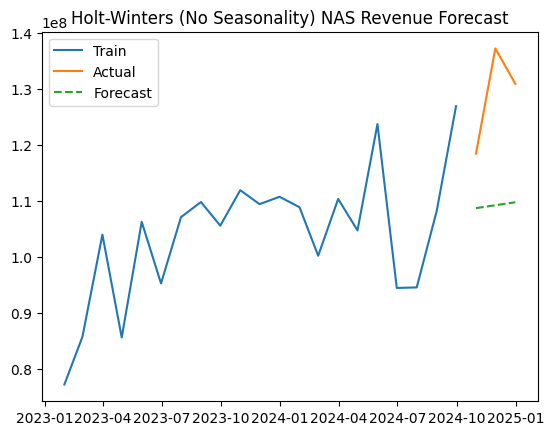

In [29]:
# log transform for stability
y_train = np.log1p(train.set_index("InvDate")["usd_adjusted_total"])
y_test  = np.log1p(test.set_index("InvDate")["usd_adjusted_total"])

# --- Fit Holt-Winters without seasonal component ---
hw_model = ExponentialSmoothing(
    y_train,
    trend="add",       # additive trend
    seasonal=None      # no seasonal pattern
).fit(optimized=True)

forecast_log = hw_model.forecast(steps=len(y_test))
forecast = np.expm1(forecast_log)
actual   = np.expm1(y_test)

mape = mean_absolute_percentage_error(actual, forecast) * 100
print(f"MAPE: {mape:.2f}%")

plt.plot(np.expm1(y_train), label="Train")
plt.plot(np.expm1(y_test), label="Actual")
plt.plot(forecast, label="Forecast", linestyle="--")
plt.legend()
plt.title("Holt-Winters (No Seasonality) NAS Revenue Forecast")
plt.show()

In [30]:
mape = mean_absolute_percentage_error(actual, forecast) * 100
print(f"MAPE: {mape:.2f}%")

MAPE: 14.91%


In [31]:
hw_model = ExponentialSmoothing(
    y_train,
    trend="add",
    seasonal="add",
    seasonal_periods=3
).fit(optimized=True)

Quarterly Holt-Winters MAPE: 9.33%


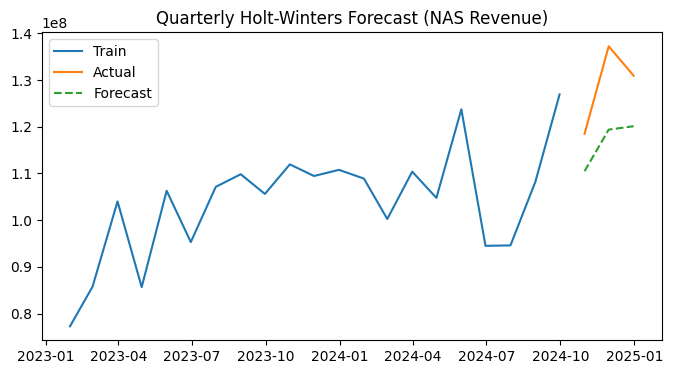

In [32]:
# log transform for stability
y_train = np.log1p(train.set_index("InvDate")["usd_adjusted_total"])
y_test  = np.log1p(test.set_index("InvDate")["usd_adjusted_total"])

# --- Fit additive trend + quarterly (3-month) seasonality ---
hw_model = ExponentialSmoothing(
    y_train,
    trend="add",
    seasonal="add",
    seasonal_periods=3
).fit(optimized=True)

# Forecast and invert log
forecast_log = hw_model.forecast(steps=len(y_test))
forecast = np.expm1(forecast_log)
actual   = np.expm1(y_test)

# Evaluate
mape = mean_absolute_percentage_error(actual, forecast) * 100
print(f"Quarterly Holt-Winters MAPE: {mape:.2f}%")

# Visualize
plt.figure(figsize=(8,4))
plt.plot(np.expm1(y_train), label="Train")
plt.plot(np.expm1(y_test), label="Actual")
plt.plot(forecast, label="Forecast", linestyle="--")
plt.legend()
plt.title("Quarterly Holt-Winters Forecast (NAS Revenue)")
plt.show()

XGBoost

In [35]:
# aggregate to monthly totals
monthly_rev = (
    suite_NAS_clean.groupby(pd.Grouper(key="InvDate", freq="M"))["usd_adjusted_total"]
    .sum()
    .reset_index()
)

# create calendar features
monthly_rev["month"]   = monthly_rev["InvDate"].dt.month
monthly_rev["quarter"] = monthly_rev["InvDate"].dt.quarter
monthly_rev["year"]    = monthly_rev["InvDate"].dt.year

# lag features (previous 1,2,3 months)
for lag in [1,2,3]:
    monthly_rev[f"lag_{lag}"] = monthly_rev["usd_adjusted_total"].shift(lag)

# drop rows with NaN lags
monthly_rev = monthly_rev.dropna().reset_index(drop=True)

# train/test split
train_df = monthly_rev[monthly_rev["InvDate"] <= "2024-09-30"]
test_df  = monthly_rev[monthly_rev["InvDate"] >  "2024-09-30"]

In [37]:
features = ["month", "quarter", "year", "lag_1", "lag_2", "lag_3"]

X_train, y_train = train_df[features], train_df["usd_adjusted_total"]
X_test,  y_test  = test_df[features],  test_df["usd_adjusted_total"]

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb.fit(X_train, y_train)

forecast = xgb.predict(X_test)
mape = mean_absolute_percentage_error(y_test, forecast) * 100
print(f"XGBoost Forecast MAPE: {mape:.2f}%")

XGBoost Forecast MAPE: 15.44%


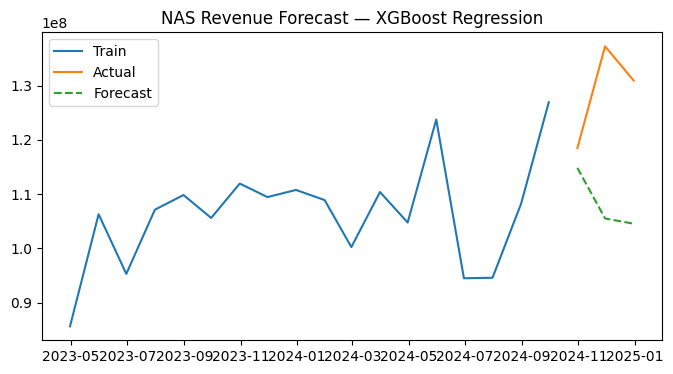

In [38]:
plt.figure(figsize=(8,4))
plt.plot(train_df["InvDate"], y_train, label="Train")
plt.plot(test_df["InvDate"], y_test, label="Actual")
plt.plot(test_df["InvDate"], forecast, label="Forecast", linestyle="--")
plt.legend()
plt.title("NAS Revenue Forecast — XGBoost Regression")
plt.show()

In [39]:
# rolling statistics
monthly_rev["roll3_mean"] = monthly_rev["usd_adjusted_total"].shift(1).rolling(3).mean()
monthly_rev["roll6_mean"] = monthly_rev["usd_adjusted_total"].shift(1).rolling(6).mean()
monthly_rev["pct_change"] = monthly_rev["usd_adjusted_total"].pct_change()

monthly_rev = monthly_rev.dropna().reset_index(drop=True)

In [40]:
train_df = monthly_rev[monthly_rev["InvDate"] <= "2024-09-30"]
test_df  = monthly_rev[monthly_rev["InvDate"] >  "2024-09-30"]

In [41]:
features = [
    "month", "quarter", "year",
    "lag_1", "lag_2", "lag_3",
    "roll3_mean", "roll6_mean", "pct_change"
]

X_train, y_train = train_df[features], train_df["usd_adjusted_total"]
X_test,  y_test  = test_df[features],  test_df["usd_adjusted_total"]

xgb = XGBRegressor(
    n_estimators=1500,
    learning_rate=0.01,
    max_depth=4,
    min_child_weight=1,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42
)
xgb.fit(X_train, y_train)

forecast = xgb.predict(X_test)
mape = mean_absolute_percentage_error(y_test, forecast) * 100
print(f"Tuned XGBoost MAPE: {mape:.2f}%")

Tuned XGBoost MAPE: 14.46%


Linear Regression

In [44]:
# monthly totals
monthly_rev = (
    suite_NAS_clean.groupby(pd.Grouper(key="InvDate", freq="M"))["usd_adjusted_total"]
    .sum()
    .reset_index()
)

# time index as numeric variable
monthly_rev["t"] = np.arange(len(monthly_rev))

# split into train/test
train = monthly_rev[monthly_rev["InvDate"] <= "2024-09-30"]
test  = monthly_rev[monthly_rev["InvDate"] >  "2024-09-30"]

In [45]:
X_train = train[["t"]]
y_train = train["usd_adjusted_total"]
X_test  = test[["t"]]
y_test  = test["usd_adjusted_total"]

lr = LinearRegression().fit(X_train, y_train)
forecast = lr.predict(X_test)

mape = mean_absolute_percentage_error(y_test, forecast) * 100
print(f"Linear Regression MAPE: {mape:.2f}%")

Linear Regression MAPE: 9.09%


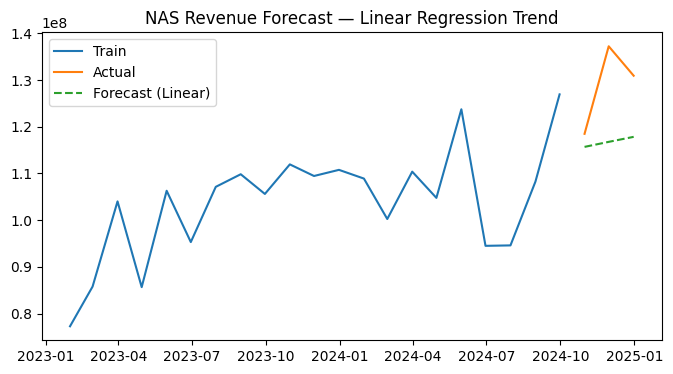

In [46]:
plt.figure(figsize=(8,4))
plt.plot(train["InvDate"], y_train, label="Train")
plt.plot(test["InvDate"], y_test, label="Actual")
plt.plot(test["InvDate"], forecast, "--", label="Forecast (Linear)")
plt.legend()
plt.title("NAS Revenue Forecast — Linear Regression Trend")
plt.show()

In [47]:
train["quarter_end"] = (train["InvDate"].dt.month % 3 == 0).astype(int)
test["quarter_end"]  = (test["InvDate"].dt.month % 3 == 0).astype(int)

X_train = train[["t", "quarter_end"]]
y_train = train["usd_adjusted_total"]
X_test  = test[["t", "quarter_end"]]
y_test  = test["usd_adjusted_total"]

lr = LinearRegression().fit(X_train, y_train)
forecast = lr.predict(X_test)

mape = mean_absolute_percentage_error(y_test, forecast) * 100
print(f"Linear + Quarter Effect MAPE: {mape:.2f}%")

Linear + Quarter Effect MAPE: 9.34%


In [49]:
quarterly = (
    suite_NAS_clean.groupby(pd.Grouper(key="InvDate", freq="Q"))["usd_adjusted_total"]
    .sum()
    .reset_index()
)
quarterly["t"] = np.arange(len(quarterly))

train = quarterly[quarterly["InvDate"] <= "2024-09-30"]
test  = quarterly[quarterly["InvDate"] >  "2024-09-30"]

lr = LinearRegression().fit(train[["t"]], train["usd_adjusted_total"])
forecast = lr.predict(test[["t"]])

mape = mean_absolute_percentage_error(test["usd_adjusted_total"], forecast)*100
print(f"Quarterly Linear MAPE: {mape:.2f}%")

Quarterly Linear MAPE: 9.92%
